<a href="https://colab.research.google.com/github/Rahulshah3006/Project_AX/blob/main/MobileTrainer_CNN_Thymio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model-1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dir = '/content/EnvIdnetification/train'
val_dir = '/content/EnvIdnetification/val'

In [7]:
# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=preprocess)
val_dataset = datasets.ImageFolder(root=val_dir, transform=preprocess)

In [20]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [21]:
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 143MB/s]


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
#Training


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Epoch [1/20], Loss: 0.13623156008543447
Epoch [2/20], Loss: 0.017237556670443153
Epoch [3/20], Loss: 0.22784044645595714
Epoch [4/20], Loss: 0.18765358762611867
Epoch [5/20], Loss: 0.030890944588463753
Epoch [6/20], Loss: 0.03829297884949483
Epoch [7/20], Loss: 0.03017997039569309
Epoch [8/20], Loss: 0.20240578205120982
Epoch [9/20], Loss: 0.03447295589139685
Epoch [10/20], Loss: 0.024358872159791645
Epoch [11/20], Loss: 0.17240094946755563
Epoch [12/20], Loss: 0.017220949636248407
Epoch [13/20], Loss: 0.013393176964018493
Epoch [14/20], Loss: 0.005913617326586973
Epoch [15/20], Loss: 0.0024623454439279156
Epoch [16/20], Loss: 0.013494752177211921
Epoch [17/20], Loss: 0.2589732105991061
Epoch [18/20], Loss: 0.156928263080772
Epoch [19/20], Loss: 0.08150200332747773
Epoch [20/20], Loss: 0.048037135961931196


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 97.38562091503267%


In [25]:
# Initialize variables for metrics
correct = 0
total = 0
all_labels = []
all_predicted = []

# Set the model to evaluation mode
model.eval()

# Turn off gradient calculation
with torch.no_grad():
    for images, labels in val_loader:  # Assuming val_loader is your validation data loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect true and predicted labels for further analysis
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

# Calculate additional metrics
accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
f1 = f1_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Print the metrics
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 97.39%
Precision: 0.9742
Recall: 0.9739
F1 Score: 0.9738


Confusion Matrix:


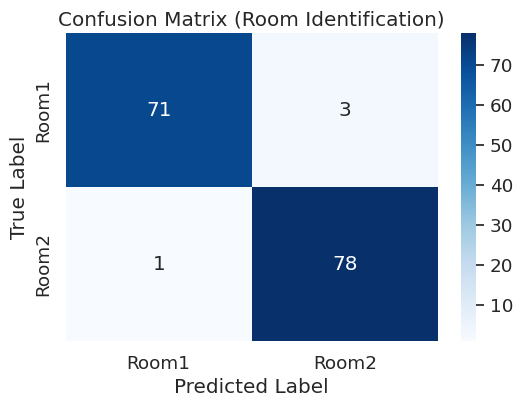

In [26]:
print('Confusion Matrix:')

# Define class names
class_names = ['Room1', 'Room2']

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Room Identification)')
plt.show()

ROC Curve:


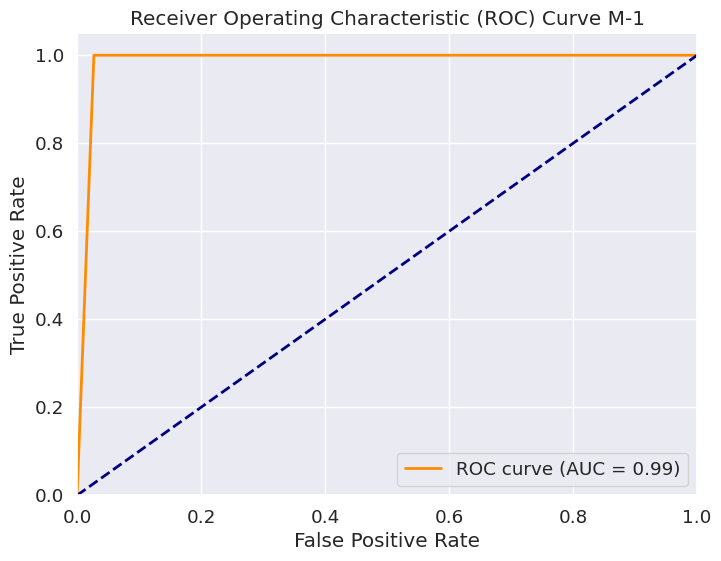

In [42]:
# Calculate the ROC curve
print("ROC Curve:")
fpr, tpr, _ = roc_curve(all_labels, all_predicted)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve M-1')
plt.legend(loc='lower right')
plt.show()

In [28]:
torch.save(model.state_dict(), 'custom_model.pth')


In [29]:
def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

In [30]:
# Example usage
image_path = '/content/EnvIdnetification/val/room2/image_2024-05-29_14-14-24.jpg'
prediction = predict_image(image_path, model, preprocess)

if prediction == 0:
    print("This is Room 1")
else:
    print("This is Room 2")

This is Room 2


#Model-2

In [31]:
'''Model-2'''
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Adjust in_channels to 3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 60 * 60, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 60 * 60)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/20], Loss: 1.4742873439390678
Epoch [2/20], Loss: 0.062127608153913626
Epoch [3/20], Loss: 0.038069315883331
Epoch [4/20], Loss: 0.024139108456802207
Epoch [5/20], Loss: 0.015535589027604147
Epoch [6/20], Loss: 0.07631345190688064
Epoch [7/20], Loss: 0.005920475509401513
Epoch [8/20], Loss: 0.0054895877334047325
Epoch [9/20], Loss: 0.0552236006647802
Epoch [10/20], Loss: 0.004254176347092198
Epoch [11/20], Loss: 0.006582277680115567
Epoch [12/20], Loss: 0.003885199390640537
Epoch [13/20], Loss: 0.0012728003762414453
Epoch [14/20], Loss: 6.917278498881352e-05
Epoch [15/20], Loss: 5.263946689471055e-05
Epoch [16/20], Loss: 0.0001632686060387023
Epoch [17/20], Loss: 0.0010545404058337371
Epoch [18/20], Loss: 0.0009770188769561705
Epoch [19/20], Loss: 0.003569398159991577
Epoch [20/20], Loss: 0.018567358130826505


In [34]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 98.69281045751634%


In [35]:
# Initialize variables for metrics
correct = 0
total = 0
all_labels = []
all_predicted = []

# Set the model to evaluation mode
model.eval()

# Turn off gradient calculation
with torch.no_grad():
    for images, labels in val_loader:  # Assuming val_loader is your validation data loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect true and predicted labels for further analysis
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

# Calculate additional metrics
accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')
f1 = f1_score(all_labels, all_predicted, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Print the metrics
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 98.69%
Precision: 0.9873
Recall: 0.9869
F1 Score: 0.9869


Confusion Matrix:


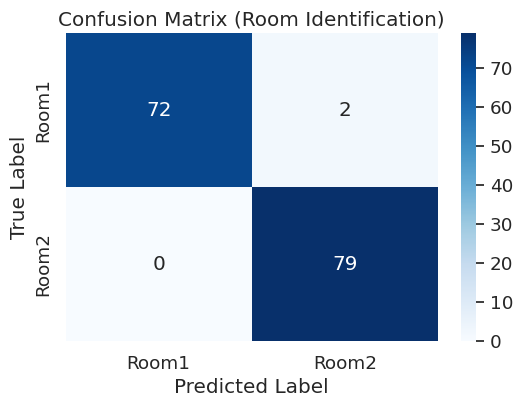

In [36]:
print('Confusion Matrix:')

# Define class names
class_names = ['Room1', 'Room2']

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Room Identification)')
plt.show()

ROC Curve:


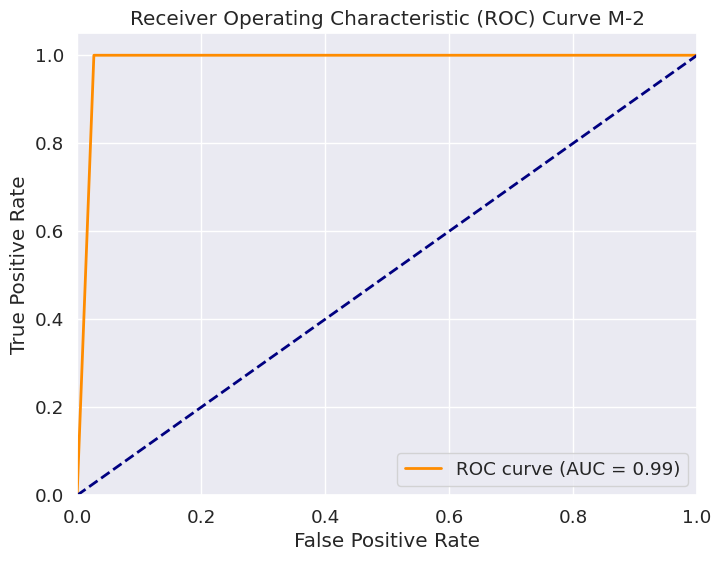

In [41]:
# Calculate the ROC curve
print("ROC Curve:")
fpr, tpr, _ = roc_curve(all_labels, all_predicted)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve M-2')
plt.legend(loc='lower right')
plt.show()

In [38]:
torch.save(model.state_dict(), 'custom_model_2.pth')


In [39]:
def predict_image(image_path, model, transform):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

In [40]:
image_path = '/content/EnvIdnetification/val/room2/image_2024-05-29_14-14-24.jpg'
prediction = predict_image(image_path, model, preprocess)

if prediction == 0:
    print("This is Room 1")
else:
    print("This is Room 2")

This is Room 2
